In [1]:
# Importing necessary Libraries for training 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pickle

C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the dataset
dataset = pd.read_csv('water_potability.csv')
print(dataset.head())

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  


In [3]:
# Handle Missing Values
dataset.fillna(dataset.mean(), inplace=True)

In [4]:
# Splitting Features and Target
X = dataset.drop("Potability", axis=1)
y = dataset["Potability"]

In [5]:
# Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [7]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [8]:
# Feature Importance Using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances.sort_values(by="Importance", ascending=False, inplace=True)
print("Feature Importances:")
print(feature_importances)

Feature Importances:
           Feature  Importance
0               ph    0.135154
4          Sulfate    0.128942
3      Chloramines    0.117442
1         Hardness    0.115573
2           Solids    0.113422
6   Organic_carbon    0.103415
5     Conductivity    0.098325
7  Trihalomethanes    0.094100
8        Turbidity    0.093627


In [9]:
# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_rf.best_params_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
# Train Random Forest with Best Parameters
rf_best = grid_rf.best_estimator_

In [11]:
# Train SVM with Best Parameters
svm = SVC(kernel='rbf', C=10, gamma='auto', probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(C=10, gamma='auto', probability=True, random_state=42)

In [12]:
# Ensemble Model Using VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('svm', svm), ('rf', rf_best)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(C=10, gamma='auto', probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [13]:
# Evaluate Models
models = {'SVM': svm, 'Random Forest': rf_best, 'Voting Classifier': voting_clf}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy * 100:.2f}%")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


SVM Accuracy: 70.62%
[[254 140]
 [ 95 311]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       394
           1       0.69      0.77      0.73       406

    accuracy                           0.71       800
   macro avg       0.71      0.71      0.70       800
weighted avg       0.71      0.71      0.71       800


Random Forest Accuracy: 73.38%
[[295  99]
 [114 292]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       394
           1       0.75      0.72      0.73       406

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800


Voting Classifier Accuracy: 73.62%
[[287 107]
 [104 302]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       394
           1       0.74      0.74      0.74       406

    accuracy           

In [14]:
# Experiment with Gradient Boosting Models
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
# Evaluate XGBoost
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 69.00%
[[271 123]
 [125 281]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       394
           1       0.70      0.69      0.69       406

    accuracy                           0.69       800
   macro avg       0.69      0.69      0.69       800
weighted avg       0.69      0.69      0.69       800



In [16]:
# Save the Best Model
pickle.dump(voting_clf, open('waterpotability_voting_model.pkl', 'wb'))

In [17]:
# Visualization Using SHAP
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_test)


SHAP Summary Plot:


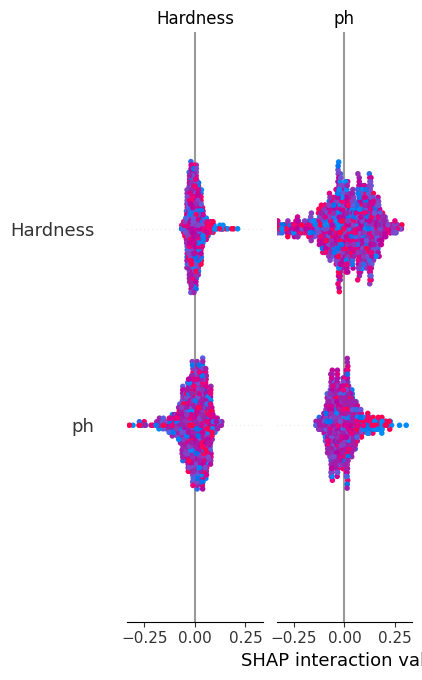

In [18]:
print("\nSHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)